## LinkedIn API Access

In [111]:
from linkedin_v2 import linkedin

API_KEY   = ''
API_SECRET = ''

RETURN_URL = 'http://localhost:8888'

authentication = linkedin.LinkedInAuthentication(API_KEY, API_SECRET, RETURN_URL, ['r_liteprofile'])

print(authentication.authorization_url)  # open this url on your browser

https://www.linkedin.com/uas/oauth2/authorization?response_type=code&client_id=77y00e34lm3qsk&scope=r_liteprofile&state=d0aa0566616d0f0a7e1181d5afbc727b&redirect_uri=http%3A//localhost%3A8888


## Retrieving your LinkedIn profile

In [114]:
authentication.authorization_code = ''
result = authentication.get_access_token()

In [117]:
app = linkedin.LinkedInApplication(token=result.access_token)

In [118]:
app

## Download your profile data and read in connections data as a CSV file

In [43]:
import os
import csv

# Point this to your 'Connections.csv' file.
CSV_FILE = os.path.join('data', 'Connections.csv')

csvReader = csv.DictReader(open(CSV_FILE, encoding='utf-8-sig'), delimiter=',', quotechar='"')
contacts = [row for row in csvReader]

In [44]:
contacts

[OrderedDict([('First Name', 'Kim'),
              ('Last Name', 'Gammeltoft'),
              ('Email Address', ''),
              ('Company', 'NNE'),
              ('Position', 'Senior Project Manager & Team Leader'),
              ('Connected On', '03.12.2018')]),
 OrderedDict([('First Name', 'Kolja'),
              ('Last Name', 'Klein'),
              ('Email Address', ''),
              ('Company', 'NNE'),
              ('Position', 'Lead Engineer'),
              ('Connected On', '27.11.2018')]),
 OrderedDict([('First Name', 'Klaudia'),
              ('Last Name', 'Knozowska'),
              ('Email Address', ''),
              ('Company', ''),
              ('Position', ''),
              ('Connected On', '07.11.2018')]),
 OrderedDict([('First Name', 'Yavuz'),
              ('Last Name', 'Baykara'),
              ('Email Address', ''),
              ('Company', 'NNE'),
              ('Position', 'Director Project Governance'),
              ('Connected On', '02.11.2018')]),
 Ord

## Simple normalization of company suffixes from address book data

In [48]:
from prettytable import PrettyTable # pip install prettytable
from collections import Counter
from operator import itemgetter

# Define a set of transforms that converts the first item
# to the second item. Here, we're simply handling some
# commonly known abbreviations, stripping off common suffixes, 
# etc.

transforms = [(', Inc.', ''), (', Inc', ''), (', LLC', ''), (', LLP', ''),
               (' LLC', ''), (' Inc.', ''), (' Inc', ''), (' AG', ''), (' Ltd', '')]

companies = [c['Company'].strip() for c in contacts if c['Company'].strip() != '']

for i, _ in enumerate(companies):
    for transform in transforms:
        companies[i] = companies[i].replace(*transform)

pt = PrettyTable(field_names=['Company', 'Freq'])
pt.align = 'l'
c = Counter(companies)

[pt.add_row([company, freq]) for (company, freq) in sorted(c.items(), key=itemgetter(1), reverse=True) if freq > 1]

print(pt)

+-----------------------------------------+------+
| Company                                 | Freq |
+-----------------------------------------+------+
| NNE                                     | 24   |
| National Technical University of Athens | 3    |
| Zaha Hadid Architects                   | 2    |
| EM2N                                    | 2    |
| Hodkinson Consultancy                   | 2    |
+-----------------------------------------+------+


## Standardizing common job titles and computing their frequencies

In [46]:
transforms = [
    ('Sr.', 'Senior'),
    ('Sr', 'Senior'),
    ('Jr.', 'Junior'),
    ('Jr', 'Junior'),
    ('CEO', 'Chief Executive Officer'),
    ('COO', 'Chief Operating Officer'),
    ('CTO', 'Chief Technology Officer'),
    ('CFO', 'Chief Finance Officer'),
    ('VP', 'Vice President'),
    ]

# Read in a list of titles and split apart
# any combined titles like "President/CEO."
# Other variations could be handled as well, such
# as "President & CEO", "President and CEO", etc.

titles = []
for contact in contacts:
    titles.extend([t.strip() for t in contact['Position'].split('/')
                  if contact['Position'].strip() != ''])

# Replace common/known abbreviations

for i, _ in enumerate(titles):
    for transform in transforms:
        titles[i] = titles[i].replace(*transform)

# Print out a table of titles sorted by frequency

pt = PrettyTable(field_names=['Job Title', 'Freq'])
pt.align = 'l'
c = Counter(titles)
[pt.add_row([title, freq]) 
 for (title, freq) in sorted(c.items(), key=itemgetter(1), reverse=True) 
     if freq > 1]
print(pt)

# Print out a table of tokens sorted by frequency

tokens = []
for title in titles:
    tokens.extend([t.strip(',') for t in title.split()])
pt = PrettyTable(field_names=['Token', 'Freq'])
pt.align = 'l'
c = Counter(tokens)
[pt.add_row([token, freq]) 
 for (token, freq) in sorted(c.items(), key=itemgetter(1), reverse=True) 
     if freq > 1 and len(token) > 2]
print(pt)

+---------------------+------+
| Job Title           | Freq |
+---------------------+------+
| Architect           | 20   |
| Junior Architect    | 4    |
| Project Architect   | 4    |
| Project Engineer    | 3    |
| Architekt           | 3    |
| Architect Engineer  | 3    |
| Senior Architect    | 3    |
| Assistant Professor | 3    |
| Lead Engineer       | 2    |
| Director            | 2    |
| Teaching Assistant  | 2    |
| Designer            | 2    |
| Urban Designer      | 2    |
| Founder             | 2    |
| Co-Founder          | 2    |
+---------------------+------+
+----------------+------+
| Token          | Freq |
+----------------+------+
| Architect      | 43   |
| Engineer       | 21   |
| Project        | 17   |
| Senior         | 13   |
| Assistant      | 12   |
| Manager        | 10   |
| Designer       | 8    |
| Director       | 7    |
| Specialist     | 7    |
| Professor      | 7    |
| Design         | 7    |
| Junior         | 5    |
| Research       | 5 

## Geocoding locations with OpenStreetMap

In [101]:
import osmnx as ox
import matplotlib.pyplot as plt
%matplotlib inline

# Specify the name that is used to seach for the data
place_name = "Altstadt, Zurich, Switzerland"

# Fetch OSM street network from the location
graph = ox.graph_from_place(place_name)
type(graph)

networkx.classes.multidigraph.MultiDiGraph

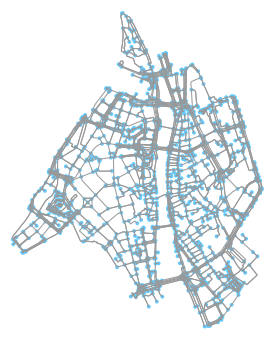

In [102]:
# Plot the streets
fig, ax = ox.plot_graph(graph)

In [103]:
import geocoder
location = geocoder.osm("ETH Zürich")

In [104]:
location.json

{'accuracy': 0.6981613543024849,
 'address': 'ETH Zürich, 101, Rämistrasse, Hochschulen, Altstadt, Zürich, Bezirk Zürich, Zürich, 8092, Schweiz/Suisse/Svizzera/Svizra',
 'bbox': {'northeast': [47.3771723, 8.5487892],
  'southwest': [47.3756849, 8.5468475]},
 'city': 'Zürich',
 'confidence': 10,
 'country': 'Schweiz/Suisse/Svizzera/Svizra',
 'country_code': 'ch',
 'county': 'Bezirk Zürich',
 'housenumber': '101',
 'importance': 0.6981613543024849,
 'lat': 47.3764534,
 'lng': 8.54770931489751,
 'ok': True,
 'osm_id': 192151232,
 'osm_type': 'way',
 'place_id': 255254827,
 'place_rank': 30,
 'postal': '8092',
 'quality': 'university',
 'raw': {'place_id': 255254827,
  'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. https://osm.org/copyright',
  'osm_type': 'way',
  'osm_id': 192151232,
  'boundingbox': ['47.3756849', '47.3771723', '8.5468475', '8.5487892'],
  'lat': '47.3764534',
  'lon': '8.54770931489751',
  'display_name': 'ETH Zürich, 101, Rämistrasse, Hochschulen, Altstadt, 

In [105]:
from geopy.geocoders import Nominatim

g = Nominatim(user_agent="https://ganagno.github.io/")

location = g.geocode("ETH Zürich")
print(location)
print('Lat/Lon: {0}, {1}'.format(location.latitude,location.longitude))
print('https://www.google.ca/maps/@{0},{1},17z'.format(location.latitude,location.longitude))

ETH Zürich, 101, Rämistrasse, Hochschulen, Altstadt, Zürich, Bezirk Zürich, Zürich, 8092, Schweiz/Suisse/Svizzera/Svizra
Lat/Lon: 47.3764534, 8.54770931489751
https://www.google.ca/maps/@47.3764534,8.54770931489751,17z


## Geocoding locations of LinkedIn connections with Nominatim

In [106]:
for i, c in enumerate(contacts):
    progress = '{0:3d} of {1:3d} - '.format(i+1,len(contacts))
    company = c['Company']
    try:
        location = g.geocode(company, exactly_one=True)
    except:
        print('... Failed to get a location for {0}'.format(company))
        location = None
    
    if location != None:
        c.update([('Location', location)])
        print(progress + company[:50] + ' -- ' + location.address)
    else:
        c.update([('Location', None)])
        print(progress + company[:50] + ' -- ' + 'Unknown Location')

  1 of 170 - NNE -- Nonera, NH719, Gwalior, Madhya Pradesh, 474001, India
  2 of 170 - NNE -- Nonera, NH719, Gwalior, Madhya Pradesh, 474001, India
  3 of 170 -  -- Unknown Location
  4 of 170 - NNE -- Nonera, NH719, Gwalior, Madhya Pradesh, 474001, India
  5 of 170 - BIMaking Engineering -- Unknown Location
  6 of 170 - NNE -- Nonera, NH719, Gwalior, Madhya Pradesh, 474001, India
  7 of 170 - NNE -- Nonera, NH719, Gwalior, Madhya Pradesh, 474001, India
  8 of 170 - NNE -- Nonera, NH719, Gwalior, Madhya Pradesh, 474001, India
  9 of 170 - NNE AG -- Nne Oyi, Isiala-Ngwa North, Abia, Nigeria
 10 of 170 - Major International EPC & Owner Operator -- Unknown Location
 11 of 170 - Amazon -- Rio Amazonas, Microrregião de Santarém, Mesorregião Baixo Amazonas, PA, Região Norte, 69100-143, Brasil
 12 of 170 - University of Southern Denmark -- SDU, Campusvej, Holluf Pile, Cortex Park, Odense Kommune, Region Syddanmark, 5230, Danmark
 13 of 170 - NNE -- Nonera, NH719, Gwalior, Madhya Pradesh, 4740

100 of 170 - Zaha Hadid Architects -- Zaha Hadid Architects, 10, Bowling Green Lane, Angel, Clerkenwell, London Borough of Islington, London, Greater London, England, EC1R 0BQ, UK
101 of 170 - Andrew Wallace Architects + Interior Designers -- Unknown Location
102 of 170 - Hellenic Army  -- Agios Andreas Emergency Reception Site, Αγίου Ανδρέου, ΚΑΑΥ Αγίου Ανδρέα, Νέα Μάκρη, Δήμος Μαραθώνος, Π.Ε. Ανατολικής Αττικής, Περιφέρεια Αττικής, Αττική, 19005, Ελλάδα
103 of 170 - Touch the Past -- Unknown Location
104 of 170 - EM2N -- Unknown Location
105 of 170 - Takenaka Corporation -- Unknown Location
106 of 170 - EM2N -- Unknown Location
107 of 170 - The British Museum -- British Museum, Great Russell Street, Holborn, Bloomsbury, London Borough of Camden, London, Greater London, England, WC1B 3DG, UK
108 of 170 -  -- Unknown Location
109 of 170 -  -- Unknown Location
110 of 170 - Hodkinson Consultancy Ltd -- Unknown Location
111 of 170 - École Nationale Supérieure d'Architecture de Marse -- EN